# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project ") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Sparkify Project '),
 ('spark.driver.port', '34649'),
 ('spark.driver.host', '067c39e682d6'),
 ('spark.app.id', 'local-1592196560546'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "mini_sparkify_event_data.json"
event_data = spark.read.json(path)

In [6]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
event_data.count()

286500

In [8]:
len(event_data.columns)

18

In [9]:
event_data.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [10]:
event_data.describe().show(2)

+-------+-----------------+------+---------+------+------------------+--------+-----------------+------+--------+------+------+--------------------+-----------------+--------+------------------+--------------------+---------+-----------------+
|summary|           artist|  auth|firstName|gender|     itemInSession|lastName|           length| level|location|method|  page|        registration|        sessionId|    song|            status|                  ts|userAgent|           userId|
+-------+-----------------+------+---------+------+------------------+--------+-----------------+------+--------+------+------+--------------------+-----------------+--------+------------------+--------------------+---------+-----------------+
|  count|           228108|286500|   278154|278154|            286500|  278154|           228108|286500|  278154|286500|286500|              278154|           286500|  228108|            286500|              286500|   278154|           286500|
|   mean|551.08520179372

In [11]:
event_data.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [12]:
event_data.select("userId").dropDuplicates().sort("userId").count()

226

In [13]:
event_data.select("sessionId").dropDuplicates().sort("sessionId").show(10)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows



In [14]:
user_log_valid = event_data.dropna(how = "any", subset = ["userId", "sessionId"])

In [15]:
user_log_valid.count()

286500

In [16]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [17]:
user_log_valid.count()

278154

In [18]:
user_log_valid.select('page').dropDuplicates().sort("page").show(50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [19]:
out_path = "mini_sparkify_event_data_cleaned0.csv"
user_log_valid.write.save(out_path, format="csv", header=True)

In [20]:
event_data_1 = spark.read.csv(out_path, header=True)

In [21]:
event_data_1.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession='50', lastName='Freeman', length='277.89016', level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration='1538173362000', sessionId='29', song='Rockpools', status='200', ts='1538352117000', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession='79', lastName='Long', length='236.09424', level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration='1538331630000', sessionId='8', song='Canada', status='200', ts='1538352180000', userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
def drawpie(axes, labels, sizes,Title,colors):
    #fig1, ax1 = plt.subplots()
    axes.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors,
        shadow=False, startangle=90,)
    axes.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axes.set_title(Title)


In [24]:
print(event_data.filter("page = 'Downgrade'").count())
print(event_data.filter("page = 'Submit Downgrade'").count())
print(event_data.filter("page = 'Cancel'").count())
print(event_data.filter("page = 'Cancellation Confirmation'").count())

2055
63
52
52


In [25]:
flag_Churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("Churn", flag_Churn_event("page"))
user_log_valid.groupBy('Churn').count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [26]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))
user_log_valid.groupBy('downgraded').count().show()

+----------+------+
|downgraded| count|
+----------+------+
|         1|    63|
|         0|278091|
+----------+------+



In [27]:
user_by_gender = user_log_valid.select('userId','gender') \
                .distinct() \
                .groupBy('gender') \
                .agg({'userId':'count'}) \
                .show()

+------+-------------+
|gender|count(userId)|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



In [28]:
user_churn_by_gender = user_log_valid.filter("Churn = 1").select('userId','gender') \
                .distinct() \
                .groupBy('gender') \
                .agg({'userId':'count'}) \
                .show()

+------+-------------+
|gender|count(userId)|
+------+-------------+
|     F|           20|
|     M|           32|
+------+-------------+



In [29]:
user_downgraded = user_log_valid.select('userId','downgraded') \
                .distinct() \
                .groupBy('downgraded') \
                .agg({'userId':'count'}) \
                .toPandas()
user_churn = user_log_valid.select('userId','Churn') \
                .distinct() \
                .groupBy('Churn') \
                .agg({'userId':'count'}) \
                .toPandas()



In [30]:
user_downgraded.iloc[:,1]

0     49
1    225
Name: count(userId), dtype: int64

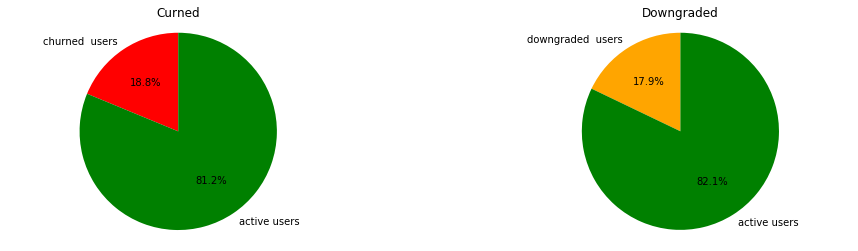

In [31]:
# Create the figure with one row and two columns. Figsize will define the figure size
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(15,4))

labels_churned = ['churned  users','active users']
labels_downgraded = ['downgraded  users','active users']


drawpie(axes[0],labels_churned,user_churn.iloc[:,1],'Curned',['red','Green'])
drawpie(axes[1],labels_downgraded,user_downgraded.iloc[:,1],'Downgraded',['Orange','Green'])

# Adjust the space between the two charts
plt.subplots_adjust(wspace=0.5)

plt.show()


In [32]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))
user_log_valid.groupBy('phase').count().show()

+-----+------+
|phase| count|
+-----+------+
|    0|214991|
|    1| 47695|
|    3|  7467|
|    2|  8001|
+-----+------+



In [33]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [34]:
event_data = user_log_valid.withColumn("hour", get_hour(event_data.ts))

In [35]:
songs_in_hour_m =event_data.filter(event_data.gender == "M").filter(event_data.page == "NextSong").groupby(event_data.hour).count().orderBy(event_data.hour.cast("float"))

In [36]:
songs_in_hour_f = event_data.filter(event_data.gender == "F").filter(event_data.page == "NextSong").groupby(event_data.hour).count().orderBy(event_data.hour.cast("float"))

In [37]:
songs_in_hour_pd_m = songs_in_hour_m.toPandas()
songs_in_hour_pd_m.hour = pd.to_numeric(songs_in_hour_pd_m.hour)

In [38]:
songs_in_hour_pd_f = songs_in_hour_f.toPandas()
songs_in_hour_pd_f.hour = pd.to_numeric(songs_in_hour_pd_f.hour)

In [39]:
songs_in_hour_pd_f['count'].describe()

count      24.000000
mean     5279.000000
std       614.142669
min      4651.000000
25%      4758.750000
50%      4939.500000
75%      5941.500000
max      6247.000000
Name: count, dtype: float64

In [40]:
songs_in_hour_pd_m['count'].describe()

count      24.000000
mean     4225.500000
std       662.392961
min      3360.000000
25%      3566.500000
50%      4188.500000
75%      4711.000000
max      5389.000000
Name: count, dtype: float64

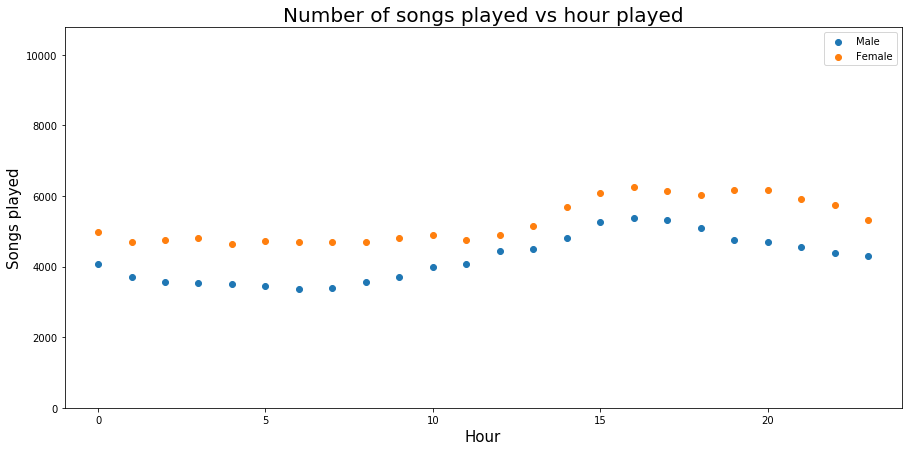

In [41]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.set_ylabel("Songs played", fontsize=15)
ax.set_xlabel('Hour', fontsize=15)
ax.set_title('Number of songs played vs hour played', fontsize=20)   
plt.scatter(songs_in_hour_pd_m["hour"], songs_in_hour_pd_m["count"],label ='Male')
plt.scatter(songs_in_hour_pd_f["hour"], songs_in_hour_pd_f["count"],label ='Feale')
plt.xlim(-1, 24);
plt.xlim(-1, 24);
plt.ylim(0, 2 * max(songs_in_hour_pd_m["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");
ax.legend( ['Male','Female' ] )

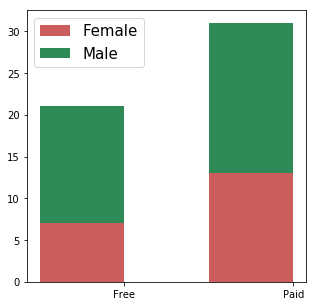

In [42]:
df_count = user_log_valid.filter(user_log_valid.Churn == 1).select('userId','gender','level').groupby('gender','level').count().toPandas().sort_values(by='count')
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
plt.rcParams["font.size"] = "15"
table = df_count.pivot(index='gender', columns='level', values='count')

bar_1 = table.iloc[0]

bar_2 = table.iloc[1]
# Range com a quantidade de itens das barras
x_pos = np.arange(len(bar_1))

first_bar = plt.bar(x_pos, bar_1, 0.5, color='indianred')
second_bar = plt.bar(x_pos, bar_2, 0.5,color='seagreen', bottom=bar_1)
# Definir position and labels for the X axis
plt.xticks(x_pos+0.25, ('Free','Paid'))
plt.legend((first_bar, second_bar), ('Female', 'Male'))
plt.grid(False)
plt.show()

In [43]:
table.head()

level,free,paid
gender,,
F,7,13
M,14,18


In [44]:
df_count_full = user_log_valid.select('userId','gender','level').groupby('userID','gender','level').count().toPandas().sort_values(by='count')


In [45]:
df_count_full[df_count_full.gender=='M'].groupby(['userID']).count()['level'].shape[0]

121

In [46]:
df_count_full.groupby(['gender','level']).count()

userID  count
gender level               
F      free       89     89
       paid       79     79
M      free      106    106
       paid       86     86

In [47]:
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- phase: long (nullable = true)



In [48]:
user_log_valid.describe().show(1)

+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+------+----------+------+
|summary|artist|  auth|firstName|gender|itemInSession|lastName|length| level|location|method|  page|registration|sessionId|  song|status|    ts|userAgent|userId| Churn|downgraded| phase|
+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+------+----------+------+
|  count|228108|278154|   278154|278154|       278154|  278154|228108|278154|  278154|278154|278154|      278154|   278154|228108|278154|278154|   278154|278154|278154|    278154|278154|
+-------+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+------+---------+------+------+----------+------+
only showing top 1 row



In [49]:
user_log_valid.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [50]:
user_log_valid.filter("auth == 'Cancelled'").groupBy('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|Cancellation Conf...|   52|
+--------------------+-----+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [51]:
def create_feature_df(df):
    '''
    -Input df
    -OUTPUT features dataframe
    heandled categorical variables using crosstable iteractions with userid
    '''
    print('Drop NaN values...')
    df_valid = df.dropna(how = "any", subset = ["gender"])
    
    print("Creating features from 'gender'...")
    df_gender = df_valid.select('userId','gender').distinct()\
                        .withColumn('is_female', (df_valid.gender == 'F').cast(IntegerType()))\
                        .sort('userId')\
                        .select('userId','is_female')
    
    print("Creating features from 'page'...")
    pages = [row[0] for row in df_valid.select('page').distinct().collect()]

    pages.remove('Cancel')
    pages.remove('Cancellation Confirmation')
    windowval = Window.partitionBy('userId')
    df_page = df_valid
    
    for page in pages:
        df_page = df_page.withColumn(page.replace(' ', ''),
                                     Fsum((df_valid.page == page).cast(IntegerType())).over(windowval))
    pages_2 = []
    for page in pages:
        pages_2.append(page.replace(' ',''))

    df_page = df_page.select('userId', *pages_2).dropDuplicates().sort('userId')
    
    print("Creating features from 'itemInSession' and 'sessionId'...")
    df_songs = df_valid.select('userId', 'sessionId','itemInSession') \
     .groupby('userId', 'sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .groupby('userId') \
                            .agg( Fsum('max(itemInSession)'), avg('max(itemInSession)'), count('sessionId') ) \
                            .withColumnRenamed('avg(max(itemInSession))','avg_count_songs_session') \
                            .withColumnRenamed('sum(max(itemInSession))','count_songs') \
                            .withColumnRenamed('count(sessionId)','count_sessions') \
                            .sort('userId')
    
    print("Creating features from 'status'...")
    status_list = [str(row[0]) for row in df_valid.select('status').distinct().collect()]
    df_status = df_valid
    for status in status_list:
        df_status = df_status.withColumn('status_'+status,
                                         Fsum((df_valid.status == status).cast(IntegerType())).over(windowval))
    df_status = df_status.select('userId','status_307','status_404','status_200').distinct().sort('userId')
    
    print("Creating features from 'phase'...")
    phase_list = [str(row[0]) for row in df_valid.select('phase').distinct().collect()]
    df_phase = df_valid
    for phase in phase_list:
        df_phase = df_phase.withColumn('phase_'+phase,
                                         Fsum((df_valid.phase == phase).cast(IntegerType())).over(windowval))
    df_phase = df_phase.select('userId','phase_0','phase_1','phase_2','phase_3').distinct().sort('userId')
    
    print("Creating features from 'level'...")
    df_level = df_valid.select('userId','level').distinct()\
                        .withColumn('user_level_paid', (df_valid.level == 'paid').cast(IntegerType()))\
                        .groupby('userId')\
                        .agg({'user_level_paid':'max'})\
                        .select('userId','max(user_level_paid)')\
                        .withColumnRenamed('max(user_level_paid)','hasPaid')\
                        .sort('userId')

    print("Creating labels...")
    df_labels = df_valid.withColumn('label', Fsum('Churn').over(windowval))
    df_labels = df_labels.select('userId', 'label').dropDuplicates().sort('userId')
    
    print("Joining all df together to df_features...")
    df_features = df_labels.select('userId', 'label')\
                    .dropDuplicates()\
                    .join(df_gender, "userId")\
                    .join(df_level, "userId")\
                    .join(df_page, "userId")\
                    .join(df_songs, "userId")\
                    .join(df_status, "userId")\
                    .join(df_phase, "userId")\
                    .dropDuplicates()\
                    .sort('userId')
    
    print("Returned df_features...")
    return df_features

In [52]:
features_df = create_feature_df(user_log_valid)

Drop NaN values...
Creating features from 'gender'...
Creating features from 'page'...
Creating features from 'itemInSession' and 'sessionId'...
Creating features from 'status'...
Creating features from 'phase'...
Creating features from 'level'...
Creating labels...
Joining all df together to df_features...
Returned df_features...


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [53]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler, Normalizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

In [54]:
features = list(features_df.columns)
features.remove('userId')
features.remove('label')
print(features)

['is_female', 'hasPaid', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'count_songs', 'avg_count_songs_session', 'count_sessions', 'status_307', 'status_404', 'status_200', 'phase_0', 'phase_1', 'phase_2', 'phase_3']


In [55]:
#Create a vectorassembler.
assembler = VectorAssembler(inputCols=features, outputCol="FeaturesVec")
features_df = assembler.transform(features_df)

In [56]:
#Normaliztion
#scaler_q1 = Normalizer(inputCol="FeaturesVec", outputCol="FeaturesVecNormalized")
#features_df = scaler_q1.transform(features_df)

In [57]:
#Scaling
scaler_q2 = StandardScaler(inputCol="FeaturesVec", outputCol="FeaturesVecScaled_S")
scalerModel_q2 = scaler_q2.fit(features_df)
features_df = scalerModel_q2.transform(features_df)

In [58]:
#from pyspark.ml.feature import MinMaxScaler
#scaler_q3 = MinMaxScaler(inputCol="FeaturesVec", outputCol="FeaturesVecMinMaxScaler")
#scalerModel_q3 = scaler_q3.fit(features_df)
#features_df = scalerModel_q3.transform(features_df)

In [59]:
# split for train and test samples
train, test = features_df.randomSplit([0.80, 0.20], seed=42)

In [60]:
#Logistic regression
lr =  LogisticRegression(labelCol='label',maxIter=5, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[lr])

In [61]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.featuresCol,['FeaturesVecScaled_S'])\
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [62]:
cvModel_1 = crossval.fit(train)

In [63]:
cvModel_1.avgMetrics

[0.6575524741067578, 0.6618365694481982]

In [64]:
preds1 = cvModel_1.bestModel.transform(test)

In [65]:
#DecisionTree
dt = DecisionTreeClassifier(labelCol="label")
paramGrid = ParamGridBuilder() \
    .addGrid(dt.featuresCol,['FeaturesVecScaled_S'])\
    .addGrid(dt.maxBins,[8, 16, 24]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [66]:
cvModel_2 = crossval.fit(train)

In [67]:
cvModel_2.avgMetrics

[0.6490147178106728, 0.634400053269249, 0.6464270490419347]

In [68]:
preds2 = cvModel_2.bestModel.transform(test)

In [69]:
#Random Forest
rf = RandomForestClassifier(labelCol='label', 
                            numTrees=10,
                            seed=42)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.featuresCol,['FeaturesVecScaled_S'])\
    .addGrid(rf.maxDepth,[5, 10 ]) \
    .addGrid(rf.maxBins,[10, 50,75]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [70]:
cvModel_3 = crossval.fit(train)

In [71]:
cvModel_3.avgMetrics

[0.6687853856604427,
 0.6756379179676723,
 0.6942947699901443,
 0.6656036077489862]

In [72]:
preds3 = cvModel_3.bestModel.transform(test)

In [73]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
f1_score = evaluator.evaluate(preds1, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(preds1, {evaluator.metricName: "accuracy"})
print('LogisticRegression')
print("F1 score: {}".format(f1_score))
print("Accuracy: {}".format(accuracy))
print(" ")

f1_score = evaluator.evaluate(preds2, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(preds2, {evaluator.metricName: "accuracy"})
print('DecisionTreeClassifier')
print("F1 score: {}".format(f1_score))
print("Accuracy: {}".format(accuracy))
print(" ")

f1_score = evaluator.evaluate(preds3, {evaluator.metricName: "f1"})
accuracy = evaluator.evaluate(preds3, {evaluator.metricName: "accuracy"})
print('RandomForestClassifier')
print("F1 score: {}".format(f1_score))
print("Accuracy: {}".format(accuracy))

LogisticRegression
F1 score: 0.7171293871136721
Accuracy: 0.8043478260869565
 
DecisionTreeClassifier
F1 score: 0.6956521739130435
Accuracy: 0.6956521739130435
 
RandomForestClassifier
F1 score: 0.6719867914144193
Accuracy: 0.717391304347826


In [80]:
Feature_importance_df = pd.DataFrame()
Feature_importance_df['Feature'] = features
Feature_importance_df['Importance'] = cvModel_2.bestModel.featureImportances.toArray()
Feature_importance_df = Feature_importance_df.sort_values(by='Importance', ascending=False)
Feature_importance_df.head(10)

,Feature,Importance
12,AddFriend,0.177057
3,ThumbsDown,0.176900
16,Upgrade,0.169778
6,RollAdvert,0.113525
4,Home,0.106937
9,About,0.094729
10,Settings,0.057821
17,Error,0.055068
21,count_sessions,0.048184
24,status_200,0.000000


In [75]:
cvModel_3.bestModel.getParam

<bound method Params.getParam of RandomForestClassificationModel (uid=RandomForestClassifier_967a14f277ac) with 10 trees>

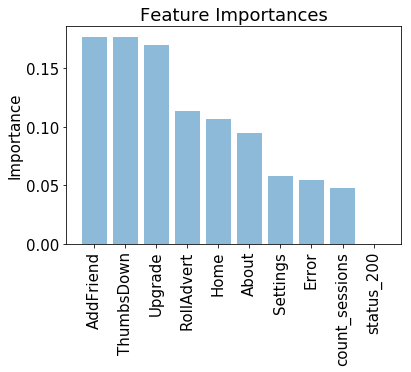

In [81]:
indexes = list(Feature_importance_df.Feature)
objects = (indexes[0], indexes[1], indexes[2], indexes[3], indexes[4], indexes[5], indexes[6], indexes[7], indexes[8], indexes[9])
y_pos = np.arange(len(objects))
performance = Feature_importance_df.iloc[:10,1]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importances')

plt.show()

In [79]:
#save the best model
cvModel_1.bestModel.save("bestmodel.model")

The best model F1 score is 71%.
In order to further improve the model, one way is to try other classifyers and tuning parameters and run on full dataset.
Also other features could be created.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb'])